In [15]:
# Cell 1 - Import libraries
import os
import sys
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns

# Set plot style
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.2)

# Custom JSON encoder to handle NumPy types
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, np.bool_):
            return bool(obj)
        return super(NumpyEncoder, self).default(obj)

In [16]:
# Cell 2 - Find and load HDF5 profile files



def find_profile_files(directory='matrix_free/results', pattern='*profile.h5'):
    """Find all profile files in the given directory"""
    import glob
    return glob.glob(os.path.join(directory, pattern))

# Find all profile files
profile_files = find_profile_files()
print(f"Found {len(profile_files)} profile files:")
for i, file in enumerate(profile_files):
    print(f"{i+1}. {os.path.basename(file)}")

# Select the most recent file
if profile_files:
    # Sort by modification time (newest first)
    profile_files.sort(key=lambda f: os.path.getmtime(f), reverse=True)
    latest_file = profile_files[0]
    print(f"\nSelected latest file: {os.path.basename(latest_file)}")
else:
    print("No profile files found.")

Found 1 profile files:
1. SIMPLE_Re100_mesh127x127_profile.h5

Selected latest file: SIMPLE_Re100_mesh127x127_profile.h5


In [17]:
# Cell 3 - Load and display metadata
def display_h5_metadata(file_path):
    """Display HDF5 metadata in a nice format"""
    with h5py.File(file_path, 'r') as f:
        # Function to recursively extract group attributes
        def extract_attrs(group):
            result = {}
            # Get attributes
            for key, value in group.attrs.items():
                result[key] = value
            
            # Process subgroups
            for key in group.keys():
                if isinstance(group[key], h5py.Group):
                    result[key] = extract_attrs(group[key])
            
            return result
        
        # Extract all metadata
        metadata = {}
        for key in f.keys():
            if key != 'residual_history':  # Skip the residual history
                metadata[key] = extract_attrs(f[key])
        
        # Return the metadata as a dictionary
        return metadata

# Load metadata from the selected file
if 'latest_file' in locals():
    metadata = display_h5_metadata(latest_file)
    
    # Display as formatted JSON
    from IPython.display import display, HTML
    display(HTML(f"<pre>{json.dumps(metadata, indent=2, cls=NumpyEncoder)}</pre>"))

In [18]:
# Cell 4 - Load and display residual history
def load_residual_history(file_path):
    """Load residual history from HDF5 file as a pandas DataFrame"""
    with h5py.File(file_path, 'r') as f:
        if 'residual_history' in f:
            # Extract all datasets in the residual_history group
            data = {}
            for key in f['residual_history'].keys():
                data[key] = f['residual_history'][key][:]
            
            # Create DataFrame
            return pd.DataFrame(data)
        else:
            return pd.DataFrame()

# Load residual history from the selected file
if 'latest_file' in locals():
    residuals = load_residual_history(latest_file)
    display(residuals.head())

,cpu_time,infinity_norm_error,iteration,momentum_residual,pressure_residual,total_residual,wall_time
0,0.402935,NaN,1,0.175000,7.081727,0.194239,0.290181
1,0.585483,NaN,2,0.125223,1.656196,0.126393,0.421574
2,0.769477,NaN,3,0.103645,0.819158,0.082657,0.556237
3,0.962262,NaN,4,0.088464,0.644644,0.060462,0.693130
4,1.154835,NaN,5,0.076228,0.618157,0.047245,0.834294


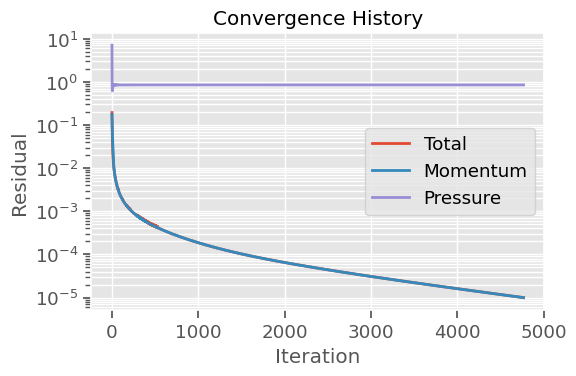

In [20]:
# Cell 5 - Plot convergence history
def plot_convergence_history(residuals):
    """Plot convergence history from residual data"""
    if residuals.empty:
        print("No residual data to plot")
        return
    
    plt.figure(figsize=(6, 4))
    plt.semilogy(residuals['iteration'], residuals['total_residual'], label='Total', linewidth=2)
    plt.semilogy(residuals['iteration'], residuals['momentum_residual'], label='Momentum', linewidth=2)
    plt.semilogy(residuals['iteration'], residuals['pressure_residual'], label='Pressure', linewidth=2)
    plt.xlabel('Iteration')
    plt.ylabel('Residual')
    plt.title('Convergence History')
    plt.legend()
    plt.grid(True, which="both", ls="-")
    plt.tight_layout()
    plt.show()

# Plot convergence history
if 'residuals' in locals() and not residuals.empty:
    plot_convergence_history(residuals)

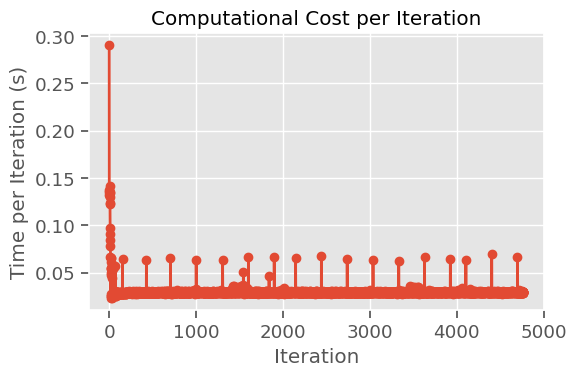

In [21]:
# Cell 6 - Plot computational cost per iteration
def plot_computational_cost(residuals):
    """Plot computational cost per iteration"""
    if residuals.empty:
        print("No residual data to plot")
        return
    
    # Calculate time per iteration (derivative of wall_time)
    time_per_iter = residuals['wall_time'].diff()
    # Replace first NaN value with first wall_time
    time_per_iter.iloc[0] = residuals['wall_time'].iloc[0]
    
    plt.figure(figsize=(6, 4))
    plt.plot(residuals['iteration'], time_per_iter, marker='o', linewidth=2)
    plt.xlabel('Iteration')
    plt.ylabel('Time per Iteration (s)')
    plt.title('Computational Cost per Iteration')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot computational cost
if 'residuals' in locals() and not residuals.empty:
    plot_computational_cost(residuals)

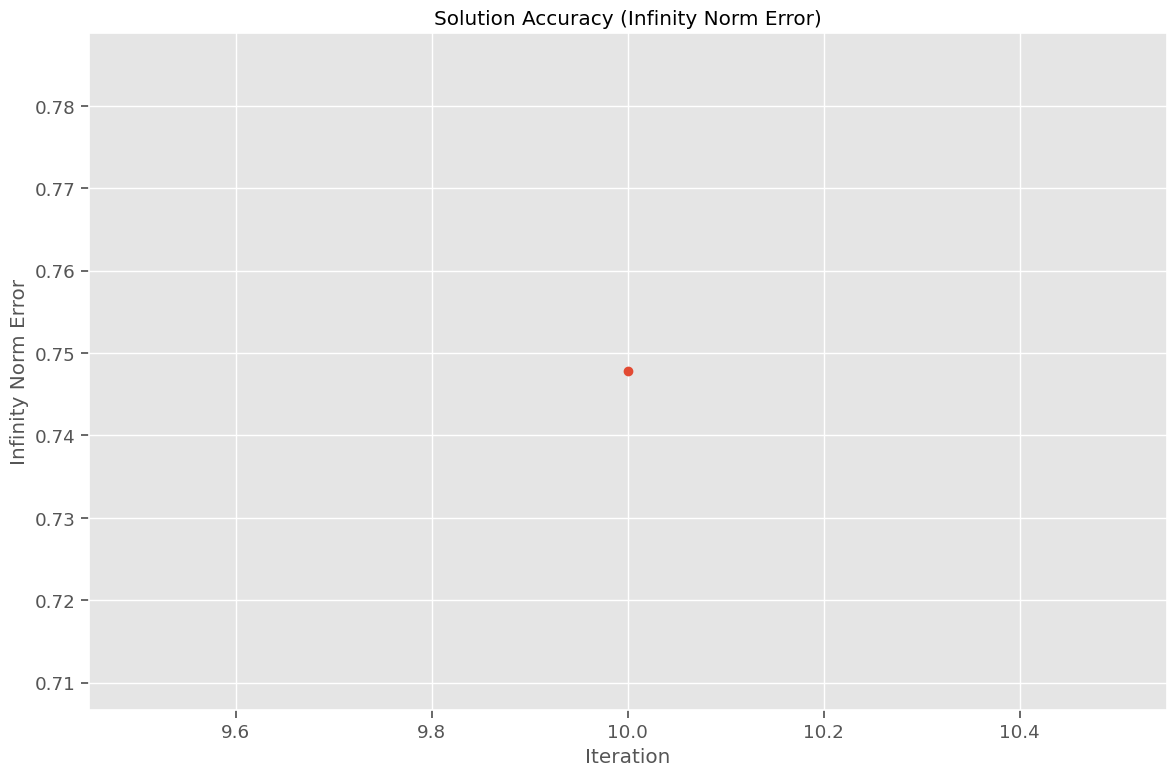

In [12]:
# Cell 7 - Plot infinity norm error (if available)
def plot_infinity_norm_error(residuals):
    """Plot infinity norm error if available"""
    if 'infinity_norm_error' not in residuals.columns or residuals['infinity_norm_error'].isna().all():
        print("No infinity norm error data available")
        return
    
    # Filter out NaN values
    valid_data = residuals.dropna(subset=['infinity_norm_error'])
    
    plt.figure(figsize=(8, 5))
    plt.plot(valid_data['iteration'], valid_data['infinity_norm_error'], marker='o', linewidth=2)
    plt.xlabel('Iteration')
    plt.ylabel('Infinity Norm Error')
    plt.title('Solution Accuracy (Infinity Norm Error)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot infinity norm error
if 'residuals' in locals() and not residuals.empty:
    plot_infinity_norm_error(residuals)

In [13]:
# Cell 8 - Extract key performance metrics
def extract_performance_metrics(metadata, residuals):
    """Extract key performance metrics from metadata and residuals"""
    metrics = {
        'Algorithm': metadata['simulation']['algorithm'],
        'Reynolds Number': metadata['simulation']['reynolds_number'],
        'Mesh Size': f"{metadata['simulation']['mesh_size']['x']}x{metadata['simulation']['mesh_size']['y']}",
        'Pressure Solver': metadata['pressure_solver']['type'],
        'Total Iterations': metadata['performance']['iterations'],
        'Total Time (s)': metadata['performance']['total_time'],
        'Time per Iteration (s)': metadata['performance']['avg_time_per_iteration'],
        'Converged': metadata['convergence']['converged'],
        'Final Residual': metadata['convergence']['final_residual']
    }
    
    # Add algorithm parameters if available
    if 'algorithm' in metadata:
        if 'alpha_p' in metadata['algorithm']:
            metrics['Pressure Relaxation (alpha_p)'] = metadata['algorithm']['alpha_p']
        if 'alpha_u' in metadata['algorithm']:
            metrics['Velocity Relaxation (alpha_u)'] = metadata['algorithm']['alpha_u']
    
    # Add multigrid parameters if available
    if 'pressure_solver' in metadata and 'multigrid' in metadata['pressure_solver']:
        mg = metadata['pressure_solver']['multigrid']
        if 'cycle_type' in mg:
            metrics['Multigrid Cycle Type'] = mg['cycle_type']
        if 'pre_smoothing' in mg:
            metrics['Pre-smoothing Steps'] = mg['pre_smoothing']
        if 'post_smoothing' in mg:
            metrics['Post-smoothing Steps'] = mg['post_smoothing']
    
    # Add smoother parameters if available
    if 'pressure_solver' in metadata and 'smoother' in metadata['pressure_solver']:
        sm = metadata['pressure_solver']['smoother']
        if 'type' in sm:
            metrics['Smoother Type'] = sm['type']
        if 'iterations' in sm:
            metrics['Smoother Iterations'] = sm['iterations']
        if 'omega' in sm:
            metrics['Smoother Relaxation (omega)'] = sm['omega']
    
    # Add infinity norm error if available
    if 'infinity_norm_error' in residuals.columns and not residuals['infinity_norm_error'].isna().all():
        metrics['Final Infinity Norm Error'] = residuals['infinity_norm_error'].dropna().iloc[-1]
    
    return pd.DataFrame([metrics])

# Extract performance metrics
if 'metadata' in locals() and 'residuals' in locals():
    performance_metrics = extract_performance_metrics(metadata, residuals)
    display(performance_metrics.T)

,0
Algorithm,SimpleSolver
Reynolds Number,100
Mesh Size,127x127
Pressure Solver,MultiGridSolver
Total Iterations,10
Total Time (s),5.236264
Time per Iteration (s),0.523626
Converged,False
Final Residual,0.022941
Pressure Relaxation (alpha_p),0.1


In [14]:
# Cell 9 - Compare multiple simulations (optional)
def load_all_profiles(profile_files):
    """Load all profile files and extract their metadata and residuals"""
    profiles = []
    
    for file_path in profile_files:
        try:
            metadata = display_h5_metadata(file_path)
            residuals = load_residual_history(file_path)
            
            profiles.append({
                'file_path': file_path,
                'metadata': metadata,
                'residuals': residuals,
                'metrics': extract_performance_metrics(metadata, residuals)
            })
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    return profiles

# Uncomment to load all profiles
# all_profiles = load_all_profiles(profile_files)
# 
# if all_profiles:
#     # Combine metrics from all profiles
#     all_metrics = pd.concat([p['metrics'] for p in all_profiles], ignore_index=True)
#     display(all_metrics)
#     
#     # Plot comparison of total time
#     plt.figure(figsize=(12, 8))
#     sns.barplot(x='Algorithm', y='Total Time (s)', hue='Reynolds Number', data=all_metrics)
#     plt.title('Total Simulation Time by Algorithm and Reynolds Number')
#     plt.ylabel('Total Time (s)')
#     plt.xlabel('Algorithm')
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()